# Heart Disease Prediction

### Problem Definition

The objective is to build a machine learning model to predict the presence of heart disease. The dataset uses the column `num` as the target. Based on the original UCI data , a value of `0` means no disease, and values `1, 2, 3, 4` indicate the presence of disease.   

We will first check the `num` column. If it has multiple values (0-4), we will engineer it into a binary target: 0 (no disease) and 1 (disease present).

Primary Metric: For this medical task, a False Negative (predicting 0 for a patient who is 1) is the worst possible error. Therefore, our models will be selected and tuned to maximize Recall.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Model & Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import export_text, plot_tree

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Evaluation
from sklearn.metrics import (
        classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, 
        RocCurveDisplay, auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

# Set plot style
# plt.style.use('fivethirtyeight')
# plt.style.use('ggplot')
# sns.set_style("whitegrid") 
sns.reset_defaults() # Reset to default settings for plotting

import warnings
warnings.filterwarnings('ignore')

### Data Loading & Exploration

In [2]:
# Load the dataset
try:
    df = pd.read_csv('data/heart_disease_uci.csv')
except FileNotFoundError:
    print("Error: 'data/heart_disease_uci.csv' not found.")
    print("Please make sure the file is in the 'data' directory.")

print("Data Shape:", df.shape)
df.head()

Data Shape: (920, 16)


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [3]:
# Check data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


In [4]:
# Check for missing values
print("Missing values per column:")
df.isnull().sum()

Missing values per column:


id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64

- `df.info()` shows several columns have missing values (e.g., trestbps, chol, fbs).   
- We will separate our features into `numerical` and `categorical` lists.
- The target variable is `num`.
- We will create a Pipeline to handle imputation and scaling automatically.

In [5]:
# Group by 'dataset' and then apply the isnull().sum() aggregation
missing_counts = df.groupby('dataset').apply(lambda x: x.isnull().sum())

# We are only interested in the key columns that had missing data
key_columns = ['trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
print("Missing values per dataset in the ORIGINAL data (for key columns):")
print(missing_counts[key_columns])

Missing values per dataset in the ORIGINAL data (for key columns):
               trestbps  chol  fbs  restecg  thalch  exang  oldpeak  slope  \
dataset                                                                      
Cleveland             0     0    0        0       0      0        0      1   
Hungary               1    23    8        1       1      1        0    189   
Switzerland           2     0   75        1       1      1        6     17   
VA Long Beach        56     7    7        0      53     53       56    102   

                ca  thal  
dataset                   
Cleveland        5     3  
Hungary        290   265  
Switzerland    118    52  
VA Long Beach  198   166  


This shows that we need to pick the `Cleveland` dataset as other datasets have a lot of missing values.

### Data Cleaning & Preprocessing

In [6]:
# --- Start of Cleaning ---

# We'll assume your DataFrame is named 'df'
# 1. Define the 13 features that are critical for the model
critical_features = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 
    'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal'
]

# 2. Create a new, clean DataFrame by dropping any rows
#    that are missing values in *any* of those 13 features.
df_cleaned = df.dropna(subset=critical_features)

print(f"Shape of original data: {df.shape}")
print(f"Shape of cleaned data: {df_cleaned.shape}")

print("\nDataset distribution *after* cleaning (should be mainly 'Cleveland'):")
print(df_cleaned['dataset'].value_counts())

# 3. Rename the 'num' column to 'target'
#    'num' is the original target variable
df_cleaned = df_cleaned.copy() # Avoid SettingWithCopyWarning

# Per the UCI spec , 0 is absence, 1-4 is presence.
# We will create a binary target where 0 stays 0, and >0 becomes 1.
df_cleaned['target'] = df_cleaned['num'].apply(lambda x: 1 if x > 0 else 0)

# 4. Create our final DataFrame with only the 13 features and our new binary target
final_columns = critical_features + ['target']
df_final = df_cleaned[final_columns]

# 5. Overwrite the old 'df' with our new, clean, final DataFrame
df = df_final

print("\n--- Cleaning Complete ---")
print(f"Final DataFrame shape: {df.shape}")
print("\nFinal DataFrame Info:")
df.info()

print("\nFinal DataFrame Head:")
df.head()

Shape of original data: (920, 16)
Shape of cleaned data: (299, 16)

Dataset distribution *after* cleaning (should be mainly 'Cleveland'):
dataset
Cleveland        297
Hungary            1
VA Long Beach      1
Name: count, dtype: int64

--- Cleaning Complete ---
Final DataFrame shape: (299, 14)

Final DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 299 entries, 0 to 748
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       299 non-null    int64  
 1   sex       299 non-null    object 
 2   cp        299 non-null    object 
 3   trestbps  299 non-null    float64
 4   chol      299 non-null    float64
 5   fbs       299 non-null    object 
 6   restecg   299 non-null    object 
 7   thalch    299 non-null    float64
 8   exang     299 non-null    object 
 9   oldpeak   299 non-null    float64
 10  slope     299 non-null    object 
 11  ca        299 non-null    float64
 12  thal      299 non-null    objec

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,target
0,63,Male,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,67,Male,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,1
2,67,Male,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,37,Male,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,41,Female,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [7]:
# These features are numerical
numerical_features = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']

# These features are categorical, even though they are encoded as numbers
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

print(f"Numerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")

Numerical features: ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
Categorical features: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']


In [8]:
# --- Implement 60/20/20 Split ---

# Separate features (X) and target (y)
X = df.drop('target', axis=1)
y = df['target']

# Split 1: 80% (train+val) and 20% (test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split 2: Split the 80% into 75% (train) and 25% (val)
# (0.75 * 0.8 = 0.6) and (0.25 * 0.8 = 0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print(f"Total size: {len(X)}")
print(f"Train set size: {len(X_train)} (~60%)")
print(f"Validation set size: {len(X_val)} (~20%)")
print(f"Test set size: {len(X_test)} (~20%)")

Total size: 299
Train set size: 179 (~60%)
Validation set size: 60 (~20%)
Test set size: 60 (~20%)


In [9]:
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal
0,60,Male,asymptomatic,145.0,282.0,False,lv hypertrophy,142.0,True,2.8,flat,2.0,reversable defect
1,48,Male,asymptomatic,122.0,222.0,False,lv hypertrophy,186.0,False,0.0,upsloping,0.0,normal
2,66,Male,asymptomatic,160.0,228.0,False,lv hypertrophy,138.0,False,2.3,upsloping,0.0,fixed defect
3,69,Male,typical angina,160.0,234.0,True,lv hypertrophy,131.0,False,0.1,flat,1.0,normal
4,42,Male,asymptomatic,140.0,226.0,False,normal,178.0,False,0.0,upsloping,0.0,normal


### Exploratory Data Analysis (EDA)

Target Variable Distribution:
target
0    160
1    139
Name: count, dtype: int64


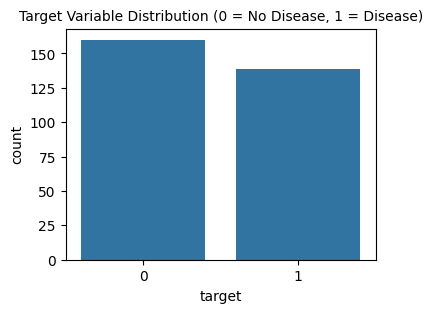

In [10]:
# 1. Analyze the Target Variable (with controlled size)
print("Target Variable Distribution:")
print(df['target'].value_counts())

# Set the figure size (width=4 inches, height=3 inches)
plt.figure(figsize=(4, 3)) 

# Plot the target variable
sns.countplot(x='target', data=df)
plt.title('Target Variable Distribution (0 = No Disease, 1 = Disease)', fontsize=10)
plt.show()

Analyzing numerical features:


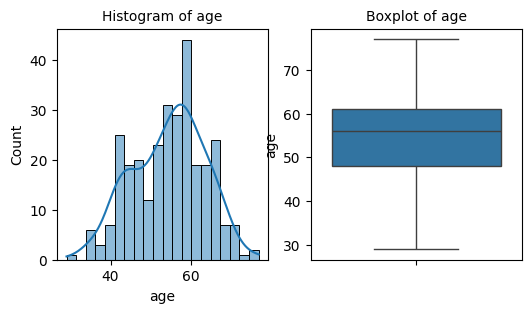

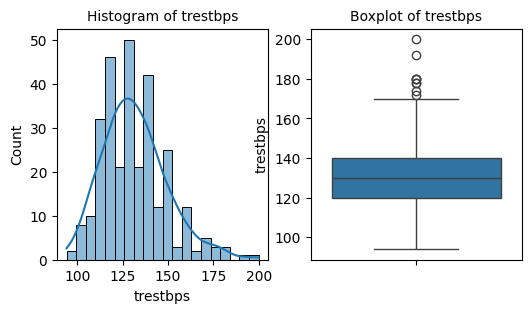

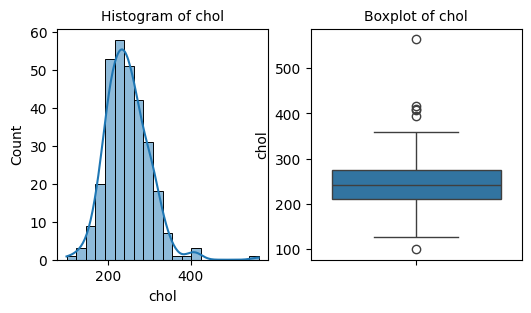

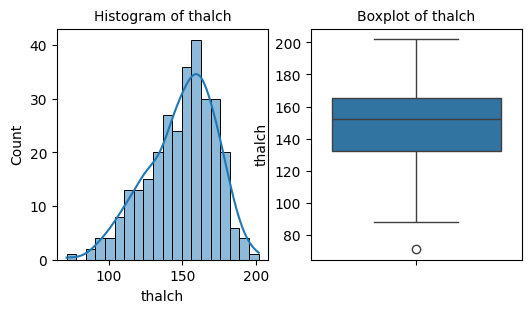

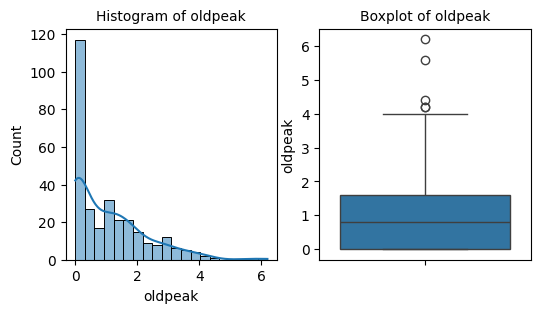

In [11]:
# 2. Analyze Numerical Features
print("Analyzing numerical features:")
for col in numerical_features:
    # Set the figure size (width=6 inches, height=3 inches)
    plt.figure(figsize=(6, 3))
    
    # Plot 1: Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(f'Histogram of {col}', fontsize=10)
    
    # Plot 2: Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}', fontsize=10)
    
    # Show the plots
    plt.show()

Numerical Feature Distributions (Training Set)


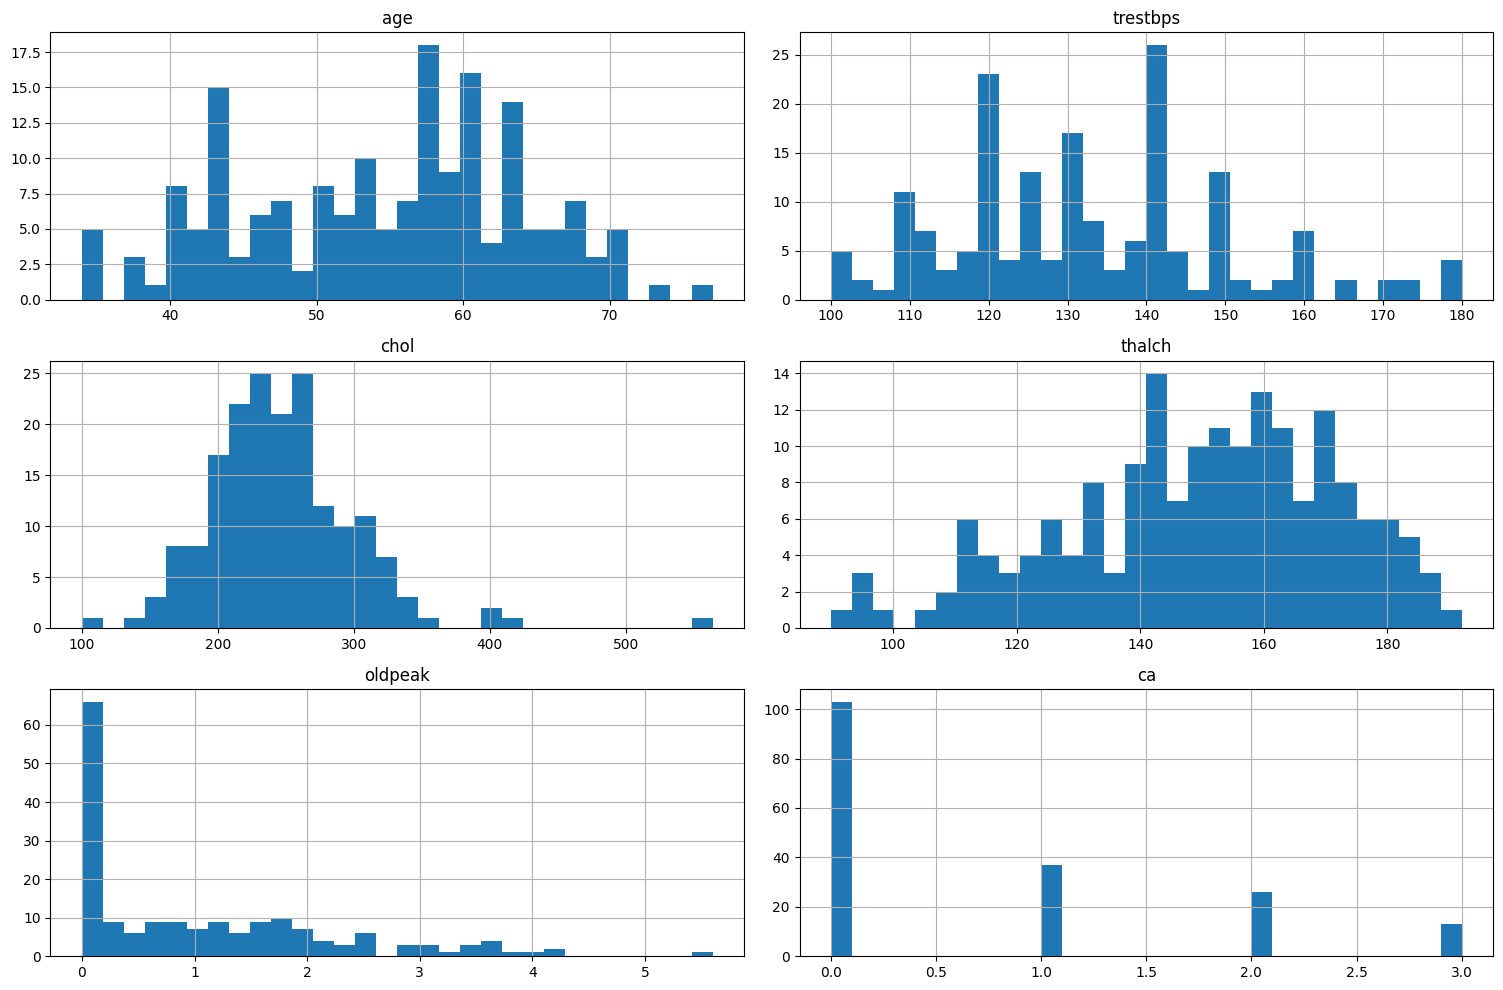

In [12]:
# Analyze Numerical Features
print("Numerical Feature Distributions (Training Set)")
X_train.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

Analyzing categorical features:


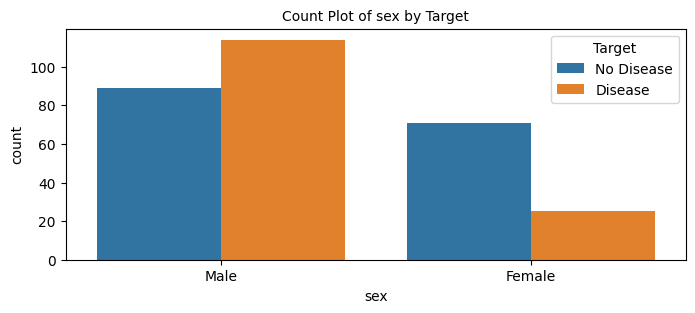

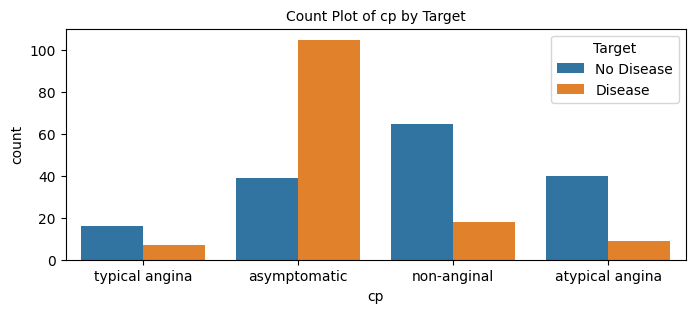

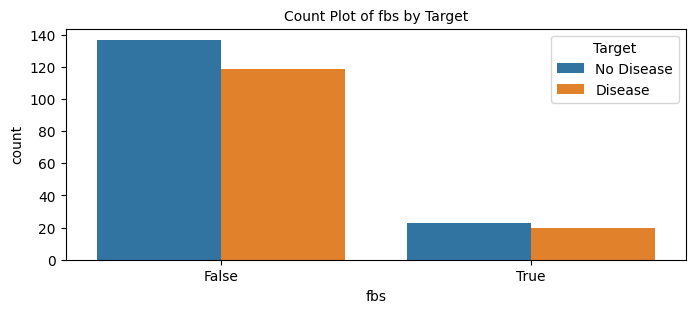

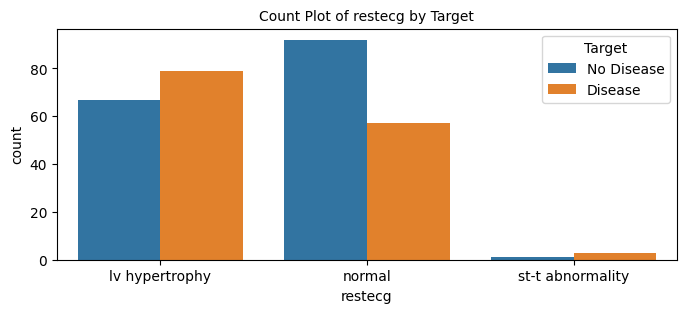

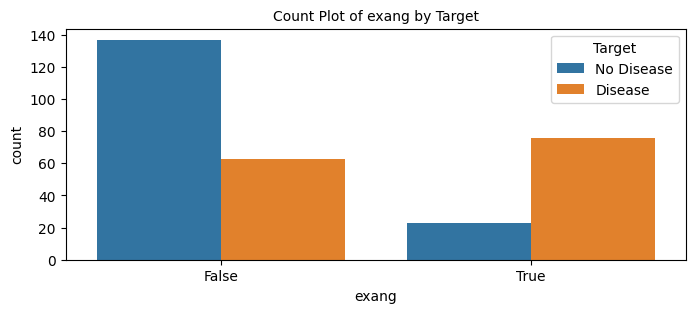

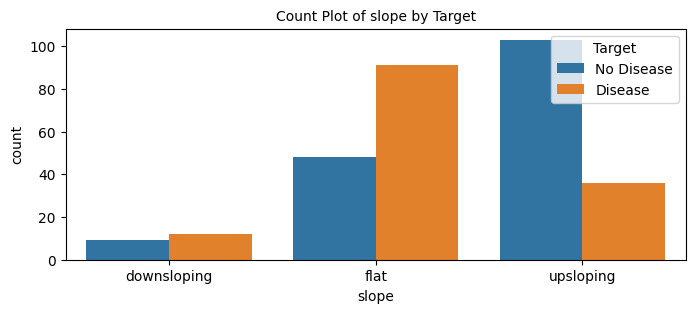

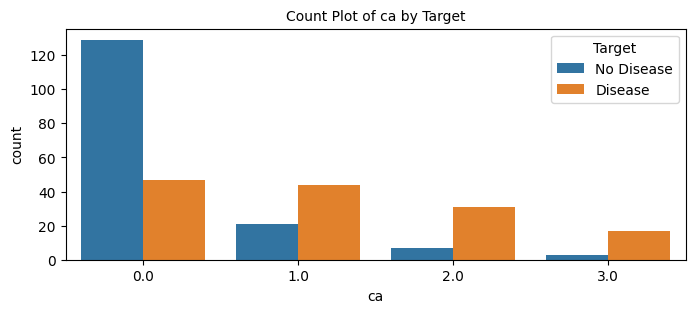

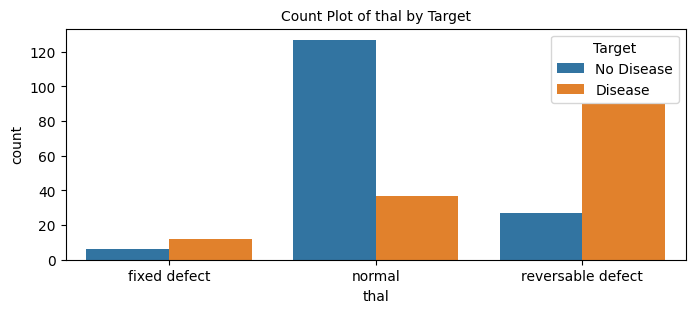

In [13]:
# 3. Analyze Categorical Features
print("Analyzing categorical features:")
for col in categorical_features:
    plt.figure(figsize=(8, 3))
    sns.countplot(x=col, data=df, hue='target')
    plt.title(f'Count Plot of {col} by Target', fontsize=10)
    plt.legend(title='Target', loc='upper right', labels=['No Disease', 'Disease'], fontsize=10)
    plt.show()

Categorical Feature Distributions (Training Set)


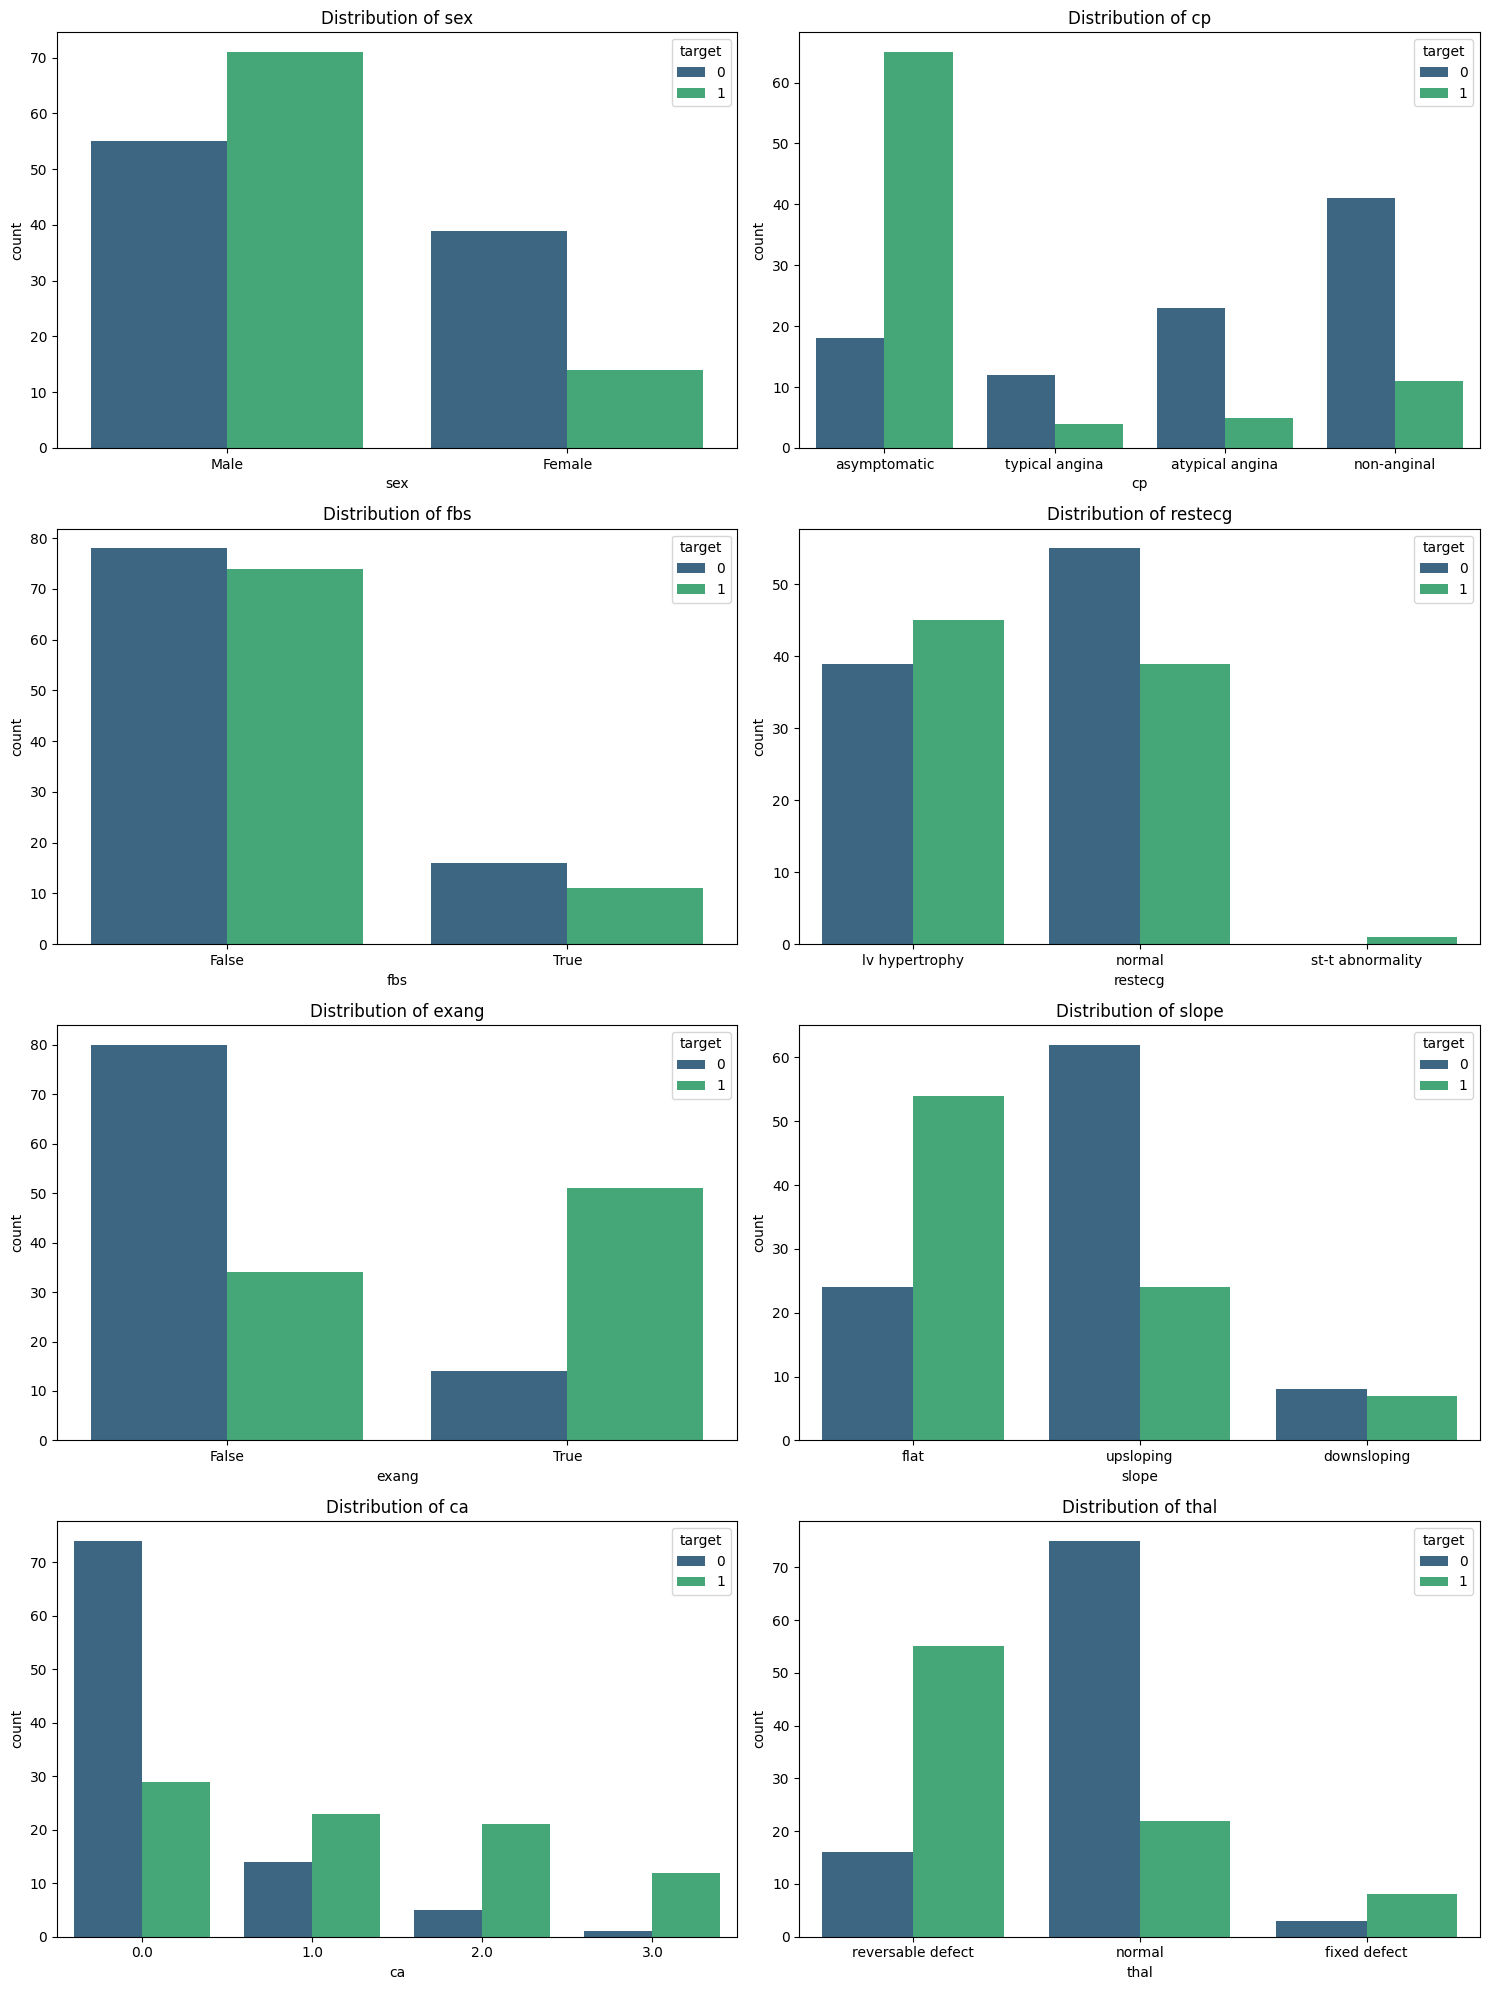

In [14]:
# Analyze Categorical Features
print("Categorical Feature Distributions (Training Set)")
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))
axes = axes.flatten()

for i, col in enumerate(categorical_features):
    sns.countplot(x=col, data=X_train, ax=axes[i], hue=y_train, palette='viridis')
    axes[i].set_title(f'Distribution of {col}')

plt.tight_layout()
if len(categorical_features) % 2!= 0:
    fig.delaxes(axes[-1]) # Remove the last empty subplot if odd number
plt.show()

Correlation Heatmap (Numerical Features):


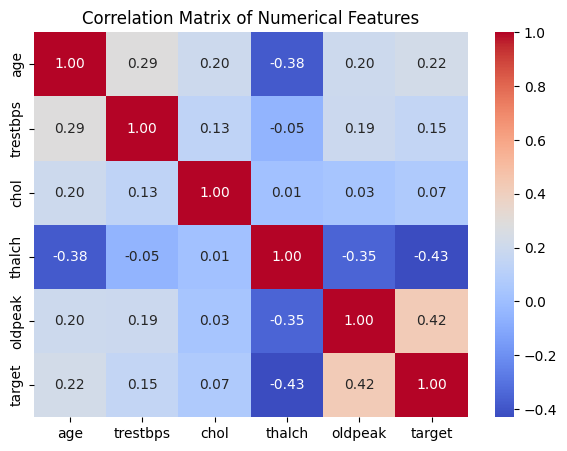

In [15]:
# 4. Check for Correlations (Numerical Features Only)
print("Correlation Heatmap (Numerical Features):")

# Select ONLY the numerical features and the target
numeric_df = df[numerical_features + ['target']]

# Create a correlation matrix
plt.figure(figsize=(7, 5))
corr_matrix = numeric_df.corr()

# Draw the heatmap
sns.heatmap(corr_matrix, 
            annot=True,     # Show the correlation values
            cmap='coolwarm',# Use a "cool" to "warm" color map
            fmt='.2f')      # Format values to 2 decimal places
            
plt.title('Correlation Matrix of Numerical Features')
plt.show()

The main purpose of that specific heatmap was to __understand the relationships between your numerical features and the target variable.__ 

It allowed us to quickly answer two key questions from EDA: 
- __Feature Importance__: Which numerical features have the strongest relationship with heart disease? (e.g., we could see if oldpeak had a strong positive correlation or if thalch had a strong negative correlation with the target). 
- __Multicollinearity__: Are any of our numerical features highly correlated with each other? (e.g., if age and chol were almost identical, we might not need both).
  
We only used the numerical features because the df.corr() function failed when it saw text values (like 'Male' in the sex column), which is what highlighted the need for feature engineering.

In [16]:
# 5. Check Categorical Feature Data Types
print("Data types of our categorical features:")

# We use our 'categorical_features' list to check just those columns
print(df[categorical_features].info())

Data types of our categorical features:
<class 'pandas.core.frame.DataFrame'>
Index: 299 entries, 0 to 748
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   sex      299 non-null    object 
 1   cp       299 non-null    object 
 2   fbs      299 non-null    object 
 3   restecg  299 non-null    object 
 4   exang    299 non-null    object 
 5   slope    299 non-null    object 
 6   ca       299 non-null    float64
 7   thal     299 non-null    object 
dtypes: float64(1), object(7)
memory usage: 21.0+ KB
None


This output will show us exactly which columns are `object` (text) and need to be encoded.

### Feature Engineering  (Categorical Encoding)

In [17]:
# --- Process Data with DictVectorizer and StandardScaler ---

# 1. Handle Categorical Data with DictVectorizer
# Convert data to list of dictionaries
train_dicts = X_train[categorical_features].to_dict(orient='records')
val_dicts = X_val[categorical_features].to_dict(orient='records')

# Initialize and fit DictVectorizer
dv = DictVectorizer(sparse=False)
X_train_cat = dv.fit_transform(train_dicts)
X_val_cat = dv.transform(val_dicts)

print(f"Categorical data shape (train): {X_train_cat.shape}")
print(f"Categorical features: {dv.get_feature_names_out()}")

# 2. Handle Numerical Data with StandardScaler
# Initialize and fit StandardScaler
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[numerical_features])
X_val_num = scaler.transform(X_val[numerical_features])

print(f"\nNumerical data shape (train): {X_train_num.shape}")

# 3. Combine the processed numerical and categorical data
X_train_final = np.hstack((X_train_num, X_train_cat))
X_val_final = np.hstack((X_val_num, X_val_cat))

print(f"\nFinal training data shape: {X_train_final.shape}")
print(f"Final validation data shape: {X_val_final.shape}")

Categorical data shape (train): (179, 18)
Categorical features: ['ca' 'cp=asymptomatic' 'cp=atypical angina' 'cp=non-anginal'
 'cp=typical angina' 'exang' 'fbs' 'restecg=lv hypertrophy'
 'restecg=normal' 'restecg=st-t abnormality' 'sex=Female' 'sex=Male'
 'slope=downsloping' 'slope=flat' 'slope=upsloping' 'thal=fixed defect'
 'thal=normal' 'thal=reversable defect']

Numerical data shape (train): (179, 5)

Final training data shape: (179, 23)
Final validation data shape: (60, 23)


#### Baseline Model (Logistic Regression)

In [18]:
# --- 4. Train and Evaluate Model (on Validation Set) ---

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_final, y_train)

# Make predictions on the VALIDATION set
y_pred_lr = lr_model.predict(X_val_final)
y_pred_proba_lr = lr_model.predict_proba(X_val_final)[:, 1]

# Evaluate
print("--- Logistic Regression (Evaluated on Validation Set) ---")
print(f"Accuracy: {accuracy_score(y_val, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_val, y_pred_lr):.4f}")
print(f"Recall: {recall_score(y_val, y_pred_lr):.4f}")
print(f"F1-Score: {f1_score(y_val, y_pred_lr):.4f}")
print(f"AUC Score: {roc_auc_score(y_val, y_pred_proba_lr):.4f}")

--- Logistic Regression (Evaluated on Validation Set) ---
Accuracy: 0.7833
Precision: 0.7857
Recall: 0.7586
F1-Score: 0.7719
AUC Score: 0.8509


##### 🎯 Why is Recall the Most Important Metric?

In this project, we are predicting heart disease.

* A **False Positive** is when our model predicts a healthy patient *has* heart disease. This is bad (causes stress, further testing), but not life-threatening.
* A **False Negative** is when our model predicts a sick patient is *healthy*. This is **extremely dangerous**. The patient might be sent home without treatment and suffer a severe or fatal heart event.

Therefore, we must minimize False Negatives. The metric that measures this is **Recall** (also called Sensitivity). We want to find as many of the *actual* positive cases as possible.

**Our goal is to build a model with the highest possible Recall, while still maintaining a reasonable Precision/AUC.**

#### Advanced Models (Random Forest and XGBoost)

In [19]:
# --- 1. Random Forest  ---
print("--- Random Forest ---")
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_final, y_train)

# Evaluate on the validation set
y_pred_rf = rf_model.predict(X_val_final)
y_pred_proba_rf = rf_model.predict_proba(X_val_final)[:, 1]

print(f"Recall: {recall_score(y_val, y_pred_rf):.4f}")
print(f"AUC Score: {roc_auc_score(y_val, y_pred_proba_rf):.4f}")

# --- 2. XGBoost  ---
print("\n--- XGBoost ---")
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_final, y_train)

# Evaluate on the validation set
y_pred_xgb = xgb_model.predict(X_val_final)
y_pred_proba_xgb = xgb_model.predict_proba(X_val_final)[:, 1]

print(f"Recall: {recall_score(y_val, y_pred_xgb):.4f}")
print(f"AUC Score: {roc_auc_score(y_val, y_pred_proba_xgb):.4f}")

--- Random Forest ---
Recall: 0.7931
AUC Score: 0.8676

--- XGBoost ---
Recall: 0.7586
AUC Score: 0.8699


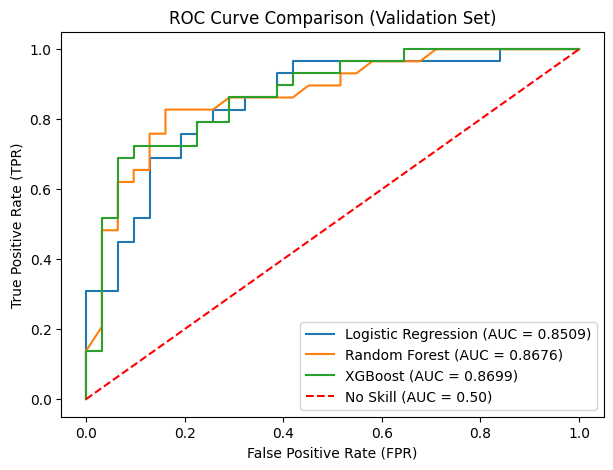

In [20]:
# --- Plotting ROC Curves ---

# 1. Get the probabilities for the validation set
y_pred_proba_lr = lr_model.predict_proba(X_val_final)[:, 1]
y_pred_proba_rf = rf_model.predict_proba(X_val_final)[:, 1]
y_pred_proba_xgb = xgb_model.predict_proba(X_val_final)[:, 1]

# 2. Calculate AUC scores
lr_auc = roc_auc_score(y_val, y_pred_proba_lr)
rf_auc = roc_auc_score(y_val, y_pred_proba_rf)
xgb_auc = roc_auc_score(y_val, y_pred_proba_xgb)

# 3. Calculate ROC curve points (FPR, TPR)
fpr_lr, tpr_lr, _ = roc_curve(y_val, y_pred_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_pred_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_val, y_pred_proba_xgb)

# 4. Plot the curves
plt.figure(figsize=(7, 5))
# sns.set_style('whitegrid') # Use a clean grid style for this plot

# Plot Logistic Regression
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {lr_auc:.4f})')

# Plot Random Forest
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_auc:.4f})')

# Plot XGBoost
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {xgb_auc:.4f})')

# Plot the "No Skill" line
plt.plot([0, 1], [0, 1], 'r--', label='No Skill (AUC = 0.50)')

# Add labels and title
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve Comparison (Validation Set)')
plt.legend()
plt.show()

Based on our project goal , __Recall is our primary metric__. Therefore, the __Random Forest__ is our winning model.

Now, let's try to tune the `RandomForestClassifier` to see if we can get that Recall and AUC even higher.

#### Hyperparameter Tuning (GridSearchCV)

n_estimators= 10: Recall: 0.7931 : AUC Score: 0.8643
n_estimators= 20: Recall: 0.7586 : AUC Score: 0.8637
n_estimators= 30: Recall: 0.7586 : AUC Score: 0.8699
n_estimators= 40: Recall: 0.7931 : AUC Score: 0.8726
n_estimators= 50: Recall: 0.7931 : AUC Score: 0.8838
n_estimators= 60: Recall: 0.7241 : AUC Score: 0.8749
n_estimators= 70: Recall: 0.7931 : AUC Score: 0.8737
n_estimators= 80: Recall: 0.8276 : AUC Score: 0.8749
n_estimators= 90: Recall: 0.8276 : AUC Score: 0.8732
n_estimators=100: Recall: 0.7931 : AUC Score: 0.8676
n_estimators=110: Recall: 0.7931 : AUC Score: 0.8699
n_estimators=120: Recall: 0.7931 : AUC Score: 0.8721
n_estimators=130: Recall: 0.7931 : AUC Score: 0.8765
n_estimators=140: Recall: 0.7931 : AUC Score: 0.8749
n_estimators=150: Recall: 0.7931 : AUC Score: 0.8715
n_estimators=160: Recall: 0.7931 : AUC Score: 0.8710
n_estimators=170: Recall: 0.7931 : AUC Score: 0.8682
n_estimators=180: Recall: 0.7931 : AUC Score: 0.8643
n_estimators=190: Recall: 0.7931 : AUC Score: 

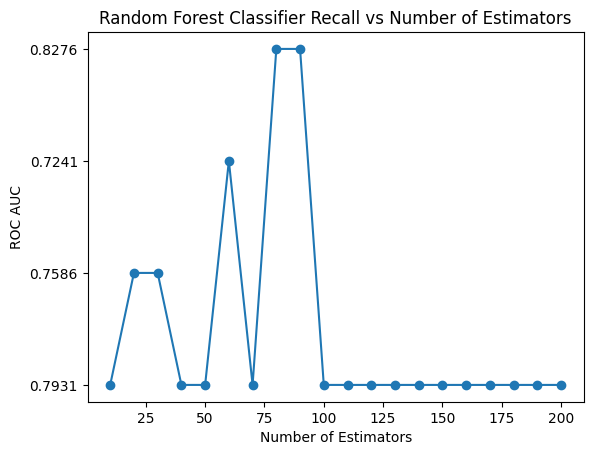

In [21]:
# Test different n_estimators values
n_estimators_values = range(10, 201, 10)
scores = []

for n in n_estimators_values:
    rf_model = RandomForestClassifier(
        n_estimators=n,
        random_state=42,
        n_jobs=-1
    )
    
    rf_model.fit(X_train_final, y_train)
    
    y_pred_rf = rf_model.predict(X_val_final)
    y_pred_proba_rf = rf_model.predict_proba(X_val_final)[:, 1]

    print(f"n_estimators={n:3d}: Recall: {recall_score(y_val, y_pred_rf):.4f} : AUC Score: {roc_auc_score(y_val, y_pred_proba_rf):.4f}")
    scores.append({
        'n_estimators': n,
        'recall': f"{recall_score(y_val, y_pred_rf):.4f}",
        'roc_auc': f"{roc_auc_score(y_val, y_pred_proba_rf):.4f}"
    })
df_scores = pd.DataFrame(scores)
plt.plot(df_scores['n_estimators'], df_scores['recall'], marker='o')
plt.xlabel('Number of Estimators')  
plt.ylabel('ROC AUC')
plt.title('Random Forest Classifier Recall vs Number of Estimators')
plt.show()  

In [22]:
all_features = list(dv.get_feature_names_out()) + list(numerical_features)
print(export_text(rf_model.estimators_[0], feature_names=all_features))

|--- thalch <= 0.50
|   |--- ca <= 0.73
|   |   |--- fbs <= 0.50
|   |   |   |--- cp=asymptomatic <= 0.77
|   |   |   |   |--- trestbps <= 0.50
|   |   |   |   |   |--- cp=asymptomatic <= -1.44
|   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |--- cp=asymptomatic >  -1.44
|   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- trestbps >  0.50
|   |   |   |   |   |--- exang <= 1.00
|   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |--- exang >  1.00
|   |   |   |   |   |   |--- class: 1.0
|   |   |   |--- cp=asymptomatic >  0.77
|   |   |   |   |--- class: 0.0
|   |   |--- fbs >  0.50
|   |   |   |--- cp=typical angina <= -0.39
|   |   |   |   |--- ca <= -1.40
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- ca >  -1.40
|   |   |   |   |   |--- oldpeak <= 0.50
|   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |--- oldpeak >  0.50
|   |   |   |   |   |   |--- sex=Female <= 0.50
|   |   |   |   |   |   |   |--- cp=non-anginal <= 0.40
|   |   | 

From the above graph we can see that `'n_estimators': [60, 70, 80, 90, 100]` is good in the mentioned range.

In [23]:
# --- Hyperparameter Tuning (Module 6) ---

# We will tune the Random Forest model since it had the best Recall

# 1. Define the parameter grid to search
# These are common parameters to tune for RandomForest
param_grid = {
    'n_estimators': range(10, 201, 10),       # Number of trees in the forest
    'max_depth': [3, 5, 7, 10],            # Maximum depth of each tree
    'min_samples_leaf': [1, 2, 4]          # Min samples required at a leaf node
}

# 2. Set up GridSearchCV
# We will score using 'recall' since that is our main metric
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='recall', # We are optimizing for Recall!
    cv=3,
    n_jobs=-1,
    verbose=1 # This will print updates as it works
)

# 3. Fit GridSearchCV on the TRAINING data
grid_search.fit(X_train_final, y_train)

# 4. Print the best parameters and the best score
print(f"\nBest parameters found: {grid_search.best_params_}")
print(f"Best Recall score (on training data): {grid_search.best_score_:.4f}")

# 5. Get the best, tuned model
best_model = grid_search.best_estimator_

# 6. Evaluate this new 'best_model' on our VALIDATION set
y_pred_best = best_model.predict(X_val_final)
y_pred_proba_best = best_model.predict_proba(X_val_final)[:, 1]

print("\n--- Tuned Random Forest (Evaluated on Validation Set) ---")
print(f"Recall: {recall_score(y_val, y_pred_best):.4f}")
print(f"AUC Score: {roc_auc_score(y_val, y_pred_proba_best):.4f}")
print(f"Accuracy: {accuracy_score(y_val, y_pred_best):.4f}")
print(f"Precision: {precision_score(y_val, y_pred_best):.4f}")

Fitting 3 folds for each of 240 candidates, totalling 720 fits

Best parameters found: {'max_depth': 5, 'min_samples_leaf': 4, 'n_estimators': 60}
Best Recall score (on training data): 0.8231

--- Tuned Random Forest (Evaluated on Validation Set) ---
Recall: 0.7931
AUC Score: 0.8687
Accuracy: 0.8000
Precision: 0.7931


##### Evaluating the best model on the unseen Test Set

--- FINAL MODEL PERFORMANCE (ON TEST SET) ---
Recall: 0.8400
AUC Score: 0.9360
Accuracy: 0.8833
Precision: 0.8750
F1-Score: 0.8571

Classification Report (Test Set):
              precision    recall  f1-score   support

  No Disease       0.89      0.91      0.90        35
     Disease       0.88      0.84      0.86        25

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60


Confusion Matrix (Test Set):


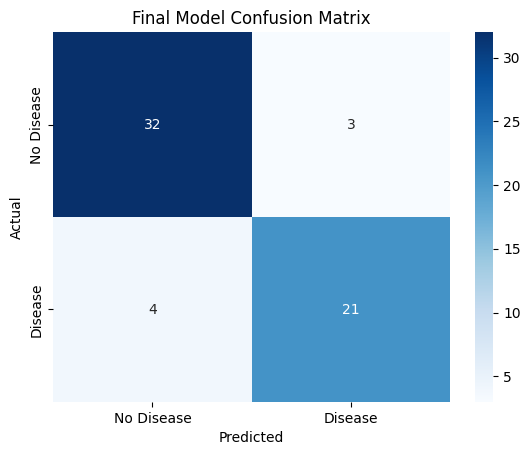

In [24]:
# --- Final Model Evaluation (on Test Set) ---

# 1. Process the TEST data (categorical)
test_dicts = X_test[categorical_features].to_dict(orient='records')
X_test_cat = dv.transform(test_dicts)

# 2. Process the TEST data (numerical)
X_test_num = scaler.transform(X_test[numerical_features])

# 3. Combine the processed test data
X_test_final = np.hstack((X_test_num, X_test_cat))

# 4. Make predictions with our BEST model
y_pred_test = best_model.predict(X_test_final)
y_pred_proba_test = best_model.predict_proba(X_test_final)[:, 1]

# 5. Print the FINAL results
print("--- FINAL MODEL PERFORMANCE (ON TEST SET) ---")
print(f"Recall: {recall_score(y_test, y_pred_test):.4f}")
print(f"AUC Score: {roc_auc_score(y_test, y_pred_proba_test):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_test):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_test):.4f}")

# 6. Show the classification report and confusion matrix
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_test, target_names=['No Disease', 'Disease']))

print("\nConfusion Matrix (Test Set):")
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Disease', 'Disease'], 
            yticklabels=['No Disease', 'Disease'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Final Model Confusion Matrix')
plt.show()